**Loading the MPII Dataset**

In [ ]:
##For Images
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz

!tar --gunzip --extract --verbose --file=mpii_human_pose_v1.tar.gz

Streaming output truncated to the last 5000 lines.
./images/019279044.jpg
./images/068025069.jpg
./images/043439489.jpg
./images/065199085.jpg
./images/043180510.jpg
./images/077936327.jpg
./images/032166247.jpg
./images/085835606.jpg
./images/028663685.jpg
./images/085061606.jpg
./images/045571938.jpg
./images/052659494.jpg
./images/040132544.jpg
./images/041967229.jpg
./images/070550266.jpg
./images/006644163.jpg
./images/004278327.jpg
./images/061707653.jpg
./images/046332890.jpg
./images/038161650.jpg
./images/014551548.jpg
./images/012610270.jpg
./images/030097552.jpg
./images/090687283.jpg
./images/092028594.jpg
./images/020276921.jpg
./images/086201772.jpg
./images/081240248.jpg
./images/045623651.jpg
./images/002182340.jpg
./images/009557537.jpg
./images/039847876.jpg
./images/001289747.jpg
./images/062442493.jpg
./images/020601740.jpg
./images/023538326.jpg
./images/087342324.jpg
./images/061328639.jpg
./images/045247005.jpg
./images/043498418.jpg
./images/087985677.jpg
./imag

**Splitting Into Training and Testing**

In [ ]:
import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):

  dirs = os.listdir(images_origin)

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  # Shuffle the files, deterministically
  filenames = [os.path.join(images_origin, f) for f in dirs if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Divide them into train/test dirs
  totalImagesSize = len(filenames)/3
  test_count = int(totalImagesSize * test_split)
  for i, file in enumerate(filenames):
    if i < test_count:
      destination = os.path.join(TEST_DIR, os.path.split(file)[1])
    else:
      destination = os.path.join(TRAIN_DIR, os.path.split(file)[1])
    shutil.copyfile(file, destination)
  print(f'Moved {test_count} of {totalImagesSize} from class "{dir}" into test.')

In [ ]:
dataset_in = '/content/images'
# if not os.path.isdir(dataset_in):
#   raise Exception("dataset_in is not a valid directory")
dataset_out = 'split_' + dataset_in
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

Moved 1665 of 8328.0 from class "<built-in function dir>" into test.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

Loading the Model

In [ ]:
# allows us to make detection

# Lightning Model for Faster Detection
interpreter_Lightning = tf.lite.Interpreter(model_path = '/content/lite-model_movenet_singlepose_lightning_3.tflite') 

# Thunder Model for Better Accuracy
interpreter_Thunder = tf.lite.Interpreter(model_path = '/content/lite-model_movenet_singlepose_thunder_3.tflite') 

# when working with tflite model
interpreter_Lightning.allocate_tensors()
interpreter_Thunder.allocate_tensors()

In [ ]:
# For connection of edges
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def movnet(input_Image,isLightning):

  image = cv2.imread(input_Image)
  plt.imshow(image)

  image.shape

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)

  if isLightning:
    input_size = 192 # for lightning model

  else:
    input_size = 256 # for thunder model

  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  input_image = tf.cast(input_image,dtype = tf.float32)
  # Above line creates a tensor

  # For showing image from a tensor we have to convert it to int first
  # plt.imshow(tf.cast(np.squeeze(input_image),dtype = tf.int32))

  # Input and Output
  if isLightning:
    input_details = interpreter_Lightning.get_input_details() 
    output_details = interpreter_Lightning.get_output_details() 
    # Make predictions 
    interpreter_Lightning.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Lightning.invoke()
    keypoints_with_scores = interpreter_Lightning.get_tensor(output_details[0]['index'])

  else:
    input_details = interpreter_Thunder.get_input_details() 
    output_details = interpreter_Thunder.get_output_details() 
    # Make predictions 
    interpreter_Thunder.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Thunder.invoke()
    keypoints_with_scores = interpreter_Thunder.get_tensor(output_details[0]['index'])


  # Above line gives us the keypoints for our image

  draw_connections(image, keypoints_with_scores, EDGES, 0.4)
  draw_keypoints(image, keypoints_with_scores, 0.4)
  plt.imshow(image)

  # cv2.imshow('MoveNet Lightning', input_image)


**Drawing Keypoints**

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    # Above line allow us to get the location of the keypoint depending on our current image original size
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

**Drawing Connections**

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

**Comparing Lightning and Thunder Models**

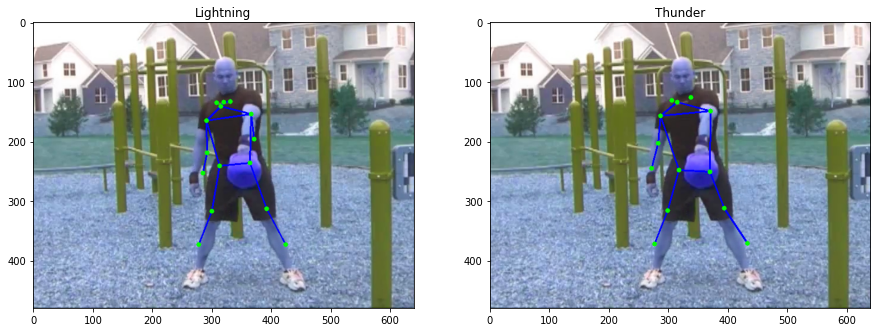

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

plt.subplot(1,2,1)
plt.title('Lightning')
movnet('/content/split_/content/images/test/010587432.jpg',True)
plt.subplot(1,2,2)
plt.title('Thunder')
movnet('/content/split_/content/images/test/010587432.jpg',False)

# plt.figure(figsize=(12, 8))

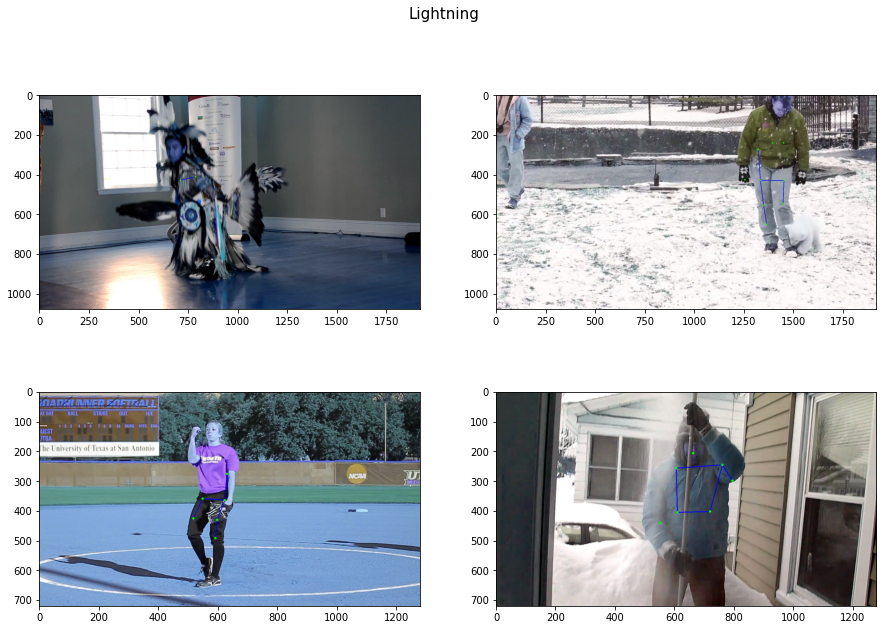

In [ ]:
dirpath = '/content/split_/content/images/train/'
filenames = random.sample(os.listdir(dirpath), 4)
row = 2
column = 2
plotno = 1
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Lightning", fontsize=15)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    plt.subplot(row,column,plotno)
    plotno += 1
    movnet(srcpath,True)

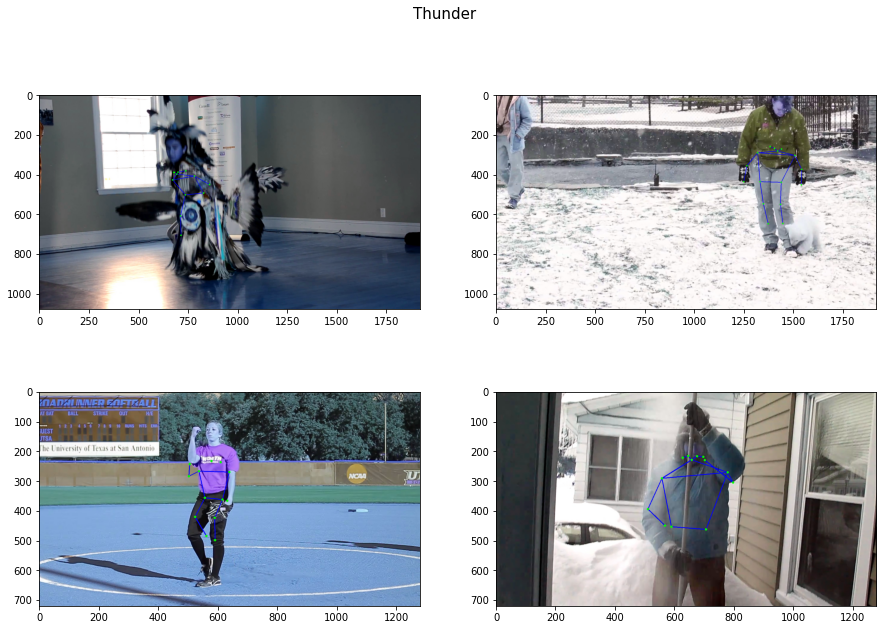

In [ ]:
row = 2
column = 2
plotno = 1
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Thunder", fontsize=15)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    plt.subplot(row,column,plotno)
    plotno += 1
    movnet(srcpath,False)